# Evaluator - Optimizer 
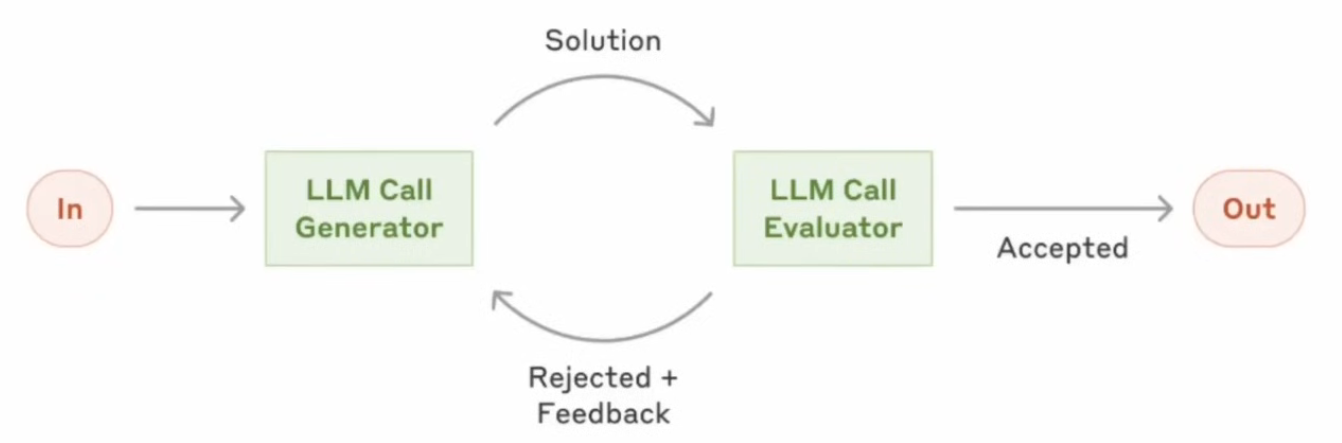

In [35]:
import os 
from langchain_openai import AzureChatOpenAI
import dotenv
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END 
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage


dotenv.load_dotenv()


llm = AzureChatOpenAI(
    openai_api_version=os.getenv("AZURE_OpenAI_API_VERSION_3"),
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT_MODEL_3'),
    model_name=os.getenv('AZURE_OPENAI_DEPLOYMENT_MODEL_3'),
    api_key=os.getenv('OPENAI_API_KEY_3'),
    azure_endpoint=os.getenv('AZURE_OpenAI_ENDPOINT_3')
   )

llm.invoke('hello').content

'Hello! How can I assist you today? 😊'

In [36]:
class Feedback(BaseModel):
    grade:Literal['sarcastic','not sarcastic']=Field(
        description='Decide if the joke is funny or not'
    )
    feedback:str=Field(
        description='If the joke is not sarcastic, provide feedback on how to improve it'
    )
# Augment the LLM with schema for structured output 
evaluate_config=llm.with_structured_output(Feedback)

In [37]:
# Graph state 
class State(TypedDict):
    joke:str 
    topic: str 
    feedback: str 
    funny_or_not: str 

In [38]:
# nodes 
def generate_joke(state:State):
    if state.get('feedback'):
        msg=llm.invoke(
            f'write a joke about {state["topic"]} but take into account the feedback: {state["feedback"]}'
        )
    else:
        msg=llm.invoke(f'write a joke about {state["topic"]}')

    return {'joke':msg.content}

def evaluate(state:State):
    grade=evaluate_config.invoke(f'grade this sarcastic joke {state["joke"]}')
    return {"funny_or_not":grade.grade,"feedback":grade.feedback}


def route_joke(state:State):
    if state["funny_or_not"]=="sarcastic":
        return "Accepted"
    elif state['funny_or_not']=="not sarcastic":
        return "Rejected + Feedback"

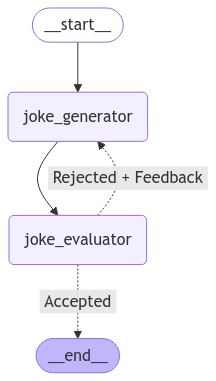

In [39]:
# Build the workflow 
builder=StateGraph(State)

builder.add_node('joke_generator',generate_joke)
builder.add_node('joke_evaluator',evaluate)

#edges 
builder.add_edge(START, 'joke_generator')
builder.add_edge('joke_generator','joke_evaluator')
builder.add_conditional_edges(
    'joke_evaluator',
    route_joke,
    {
        'Accepted':END,
        'Rejected + Feedback':'joke_generator'
    }
)

graph=builder.compile()
graph

In [40]:
response=graph.invoke({'topic':'batman and joker'})
response

{'joke': 'Sure, here\'s a refined joke based on your feedback:\n\n---\n\nBatman and the Joker are playing Pictionary during a rare truce.\n\nThe Joker draws a wavy line on the board, grinning ear to ear.  \nBatman squints at it and growls, "Is that supposed to be *chaos?*"  \nThe Joker chuckles and says, "No, Batsy, it\'s *the line you refuse to cross!*"  \n\nBatman glares and responds, “…Funny, because you still can’t draw it straight.”',
 'topic': 'batman and joker',
 'feedback': 'The joke already employs sarcasm effectively and intertwines humor with the dynamics of the Batman and Joker rivalry. No changes are needed as the clever comeback and situation are already engaging.',
 'funny_or_not': 'sarcastic'}